In [1]:
### Load test dataset from npz and models from keras tuner results ###

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

# Load train data
npz_data = np.load('data/audiobooks_data_split_smote.npz')
X_test = tf.convert_to_tensor(npz_data['X_test'], dtype=tf.float64)
y_test = tf.convert_to_tensor(npz_data['y_test'], dtype=tf.int8)
print(f'Data successfully loaded: {X_test.shape=}, {y_test.shape=}')

# Re-build model to access keras tuner project results
def build_model(hp):
    """Model building function."""

    # Define hyperparameters to tune
    num_hidden_layers = hp.Int('num_layers', min_value=2, max_value=5, default=3)
    hidden_layer_size = hp.Int('hidden_layer_size', min_value=16, max_value=128, step=16, default=64)
    activation = hp.Choice('activation', values=['relu', 'tanh', 'selu'], default='relu')
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.2, step=0.05)
    l2_strength = hp.Float('l2_strength', min_value=1e-5, max_value=1e-2, default=0.001, step=1e-5)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, default=1e-3, step=1e-4)

    # Build the model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(10,)))
    for _ in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                hidden_layer_size,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.l2(l2_strength)
            )
        )
        # Dropout layer after each Dense layer
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(2,activation='softmax',))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner_smote = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=150,
    factor=3,
    directory='tuning_results',
    project_name='smote_balance_approach',
    overwrite=False # IMPORTANT: Add this parameter!
)

# Reload existing results
tuner_smote.reload()

Data successfully loaded: X_test.shape=TensorShape([2370, 10]), y_test.shape=TensorShape([2370])
Reloading Tuner from tuning_results\smote_balance_approach\tuner0.json


In [2]:
### Create a final ensembled model ###

num_to_ensemble = 2
ensembled_models = tuner_smote.get_best_models(num_models=num_to_ensemble)

c:\Users\alowe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\alowe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
### Finally, evaluate the model on the test dataset ###

# Get predicted class probabilities and stack them
test_probabilities = [model.predict(X_test)[:, 1] for model in ensembled_models]
test_probabilities_stack = np.stack(test_probabilities, axis=0)

# Average probabilities across models and convert to 0 or 1
avg_test_probabilities = np.mean(test_probabilities_stack, axis=0)
final_test_predictions = (avg_test_probabilities > 0.5).astype(int)

# Compute the ensemble's accuracy
ensemble_test_accuracy = np.mean(final_test_predictions == y_test)
print(f"Final Model - Test Accuracy: {ensemble_test_accuracy * 100:.2f}%")

# Calculate ensemble's val_loss using sparse categorical crossentropy
ensemble_test_predictions = np.stack([1 - avg_test_probabilities, avg_test_probabilities], axis=-1)
ensemble_test_loss = tf.keras.losses.sparse_categorical_crossentropy(
    y_test, ensemble_test_predictions
).numpy()
avg_test_loss = np.mean(ensemble_test_loss)
print(f"Final Model - Test Loss: {avg_test_loss:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Final Model - Test Accuracy: 82.62%
Final Model - Test Loss: 0.3306


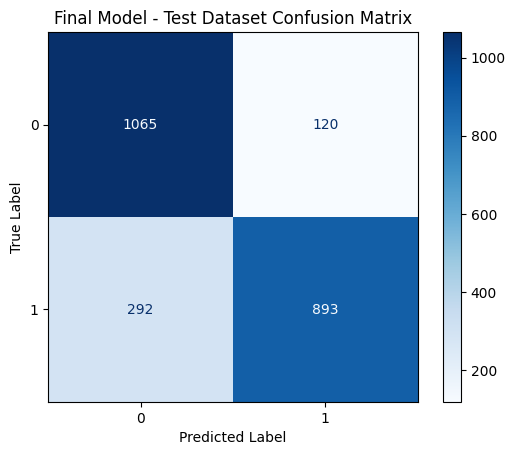

In [7]:
### Confusion Matrix ###

# Compute and plot the confusion matrix using
cm = confusion_matrix(y_test, final_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

# Show plot
plt.title('Final Model - Test Dataset Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
